In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras import initializers

from PIL import Image
import pandas as pd
import glob
import cv2

In [3]:
os.environ["KERAS_BACKEND"] = "tensorflow"
np.random.seed(10)
random_dim = 100

In [4]:
from google.colab import drive
drive.mount('drive', force_remount=True)

Mounted at drive


In [5]:
data = '/content/drive/MyDrive/GANs2/'
No_brain_tumor = '/content/drive/MyDrive/GANs2/No'
Yes_brain_tumor = '/content/drive/MyDrive/GANs2/Yes'

In [6]:
data = []
paths = []
result = []
image_list = []
for filename in glob.glob('/content/drive/MyDrive/GANs2/No/*.*'): 
    img=Image.open(filename)
    image_list.append(img)
    img = img.resize((128,128))
    img = np.array(img)
    data.append(img)

In [9]:
len(image_list),len(data)

(170, 170)

In [10]:
new_data = []
for i in data:
  if len(i.shape) > 2 and i.shape[2] == 4:
      i = cv2.cvtColor(i, cv2.COLOR_BGRA2BGR)
  if len(i.shape) > 2 and i.shape[2] == 3:
      i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
  new_data.append(i)
new_data = np.array(new_data)

In [11]:
print(new_data.shape)
new_data = (new_data.astype(np.float32) - 127.5)/127.5
new_data = new_data.reshape(new_data.shape[0],new_data.shape[1]*new_data.shape[1])
print(new_data.shape)

(170, 128, 128)
(170, 16384)


In [12]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(16384, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=16384, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [13]:
from past.builtins import xrange

epochs = 1
batch_size = 10

# Split the training data into batches of size 10
x_train = new_data
batch_count = x_train.shape[0] / batch_size

# Build our GAN netowrk
adam = get_optimizer()
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, random_dim, generator, adam)

for e in xrange(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(xrange(int(batch_count))):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])
        image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

        # Generate fake images
        generated_images = generator.predict(noise)
        X = np.concatenate([image_batch, generated_images])

        # Labels for generated and real data
        y_dis = np.zeros(2*batch_size)
        # One-sided label smoothing
        y_dis[:batch_size] = 0.9

        # Train discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(noise, y_gen)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 1 ---------------


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


In [22]:
# Create a wall of generated images
noise = np.random.normal(0, 1, size=[64, random_dim])
generated_images = generator.predict(noise)
generated_images = generated_images.reshape(64, 128, 128)

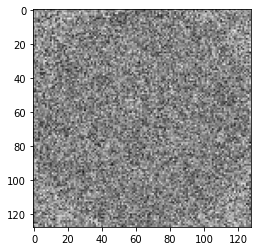

In [27]:
plt.imshow(generated_images[0], cmap='gray_r')

In [ ]:
for i in range(64):
  plt.savefig(generated_images[i], "/content/drive/MyDrive/GANs2/Generated/%d.JPG" %i, normalize = True)